## Consolidating our model runs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
from scipy.stats import gaussian_kde
sns.set_context('poster')
# sns.set_context('paper')
sns.set_palette('colorblind')

/Users/Oliver/Library/Python/3.7/lib/python/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
ati = pd.read_csv('../data/atium.csv', index_col=0)
f_ati = pd.read_csv('../data/atium.csv', index_col=0)
ati = ati[ati.eye_flag != 3]

ati.drop(ati[ati.KIC == 6603624].index, inplace=True)
ati.drop(ati[ati.KIC == 8760414].index, inplace=True)
ati.drop(ati[ati.KIC == 8938364].index, inplace=True)
print(f'Working with {len(ati)} stars')

Working with 91 stars


Reading in the posterior samples

In [3]:
%%time
# d = '/home/oliver/PhD/mnt/RDS/malatium/models_upgrade/'
d = '/Users/Oliver/Desktop/Models/'
post_pa = []
i = 0
for idx, kic in list(zip(ati.index.values, ati.KIC.values)):
    try:
        post_pa.append(1 - pd.read_csv(f"{d}{int(kic)}_samples.csv")['P_A'])
        i += 1
    except FileNotFoundError:
        print(f'File not found for index {idx}')
        print(kic)
        try:
            ati.drop(index=idx, inplace=True)
        except KeyError:
            print('Unique KIC 8760414 duplicate exclusion problem')
        continue               

File not found for index 19
7106245
File not found for index 75
6278762
CPU times: user 11.9 s, sys: 3.37 s, total: 15.3 s
Wall time: 16.5 s


In an ideal world, we would multiply the posterior functions for every star. However we have samples instead of functions. We overcome this by multiplying the probability value in each of 100 bins for all stars, approximating the shape of a combined posterior function.

In [4]:
bins = np.linspace(0, 1, 101)
hists = np.array([np.histogram(n, bins=bins, density=True)[0] for n in post_pa])

### The overall result:

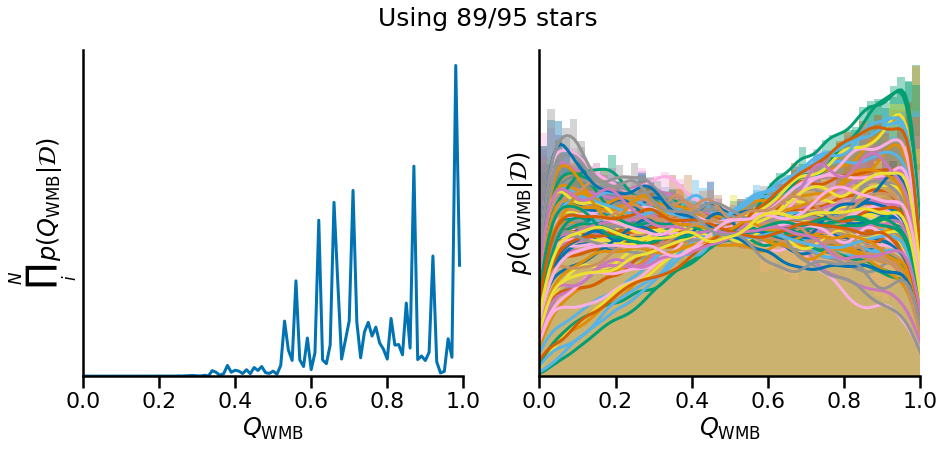

In [5]:
posterior = np.prod(hists, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(bins[:-1], posterior)
# ax[0].set_xlabel('Probability Jen is wrong')
ax[0].set_xlabel(r'$Q_{\rm WMB}$')
ax[0].set_ylabel(r'$\prod_i^N\ p(Q_{\rm WMB} | \mathcal{D})$')
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)
for n in post_pa:
    sns.distplot(n[np.isfinite(n)], ax=ax[1])
ax[1].set_ylabel(r'$p(Q_{\rm WMB} | \mathcal{D})$')
ax[1].set_xlabel(r'$Q_{\rm WMB}$')
ax[1].set_xlim(0, 1)
ax[1].get_yaxis().set_ticks([])
sns.despine()

fig.suptitle(fr'Using {len(post_pa)}/95 stars', fontsize=25)

plt.show()

### A check on convergence 

While we appear to have decent convergence on all parameters, there are some with low numbers of effective samples, or Rhat values that are high enough to raise eyebrows a little. We'll run the same checks, but with those removed.

We'll remove all stars with:
- Any of the core 4 parameters outside the KDE range (as in the example above)
- $n_{\rm eff} < 1000$ on splitting.
- $\hat{R} > 1.1$ on a rotational parameter.

In [6]:
c2 = ati.copy(deep=True)
sel = (c2.neff_split > 1000) & (c2.rhat_flag != 'rhat_1')
hists_sel_cov = hists[sel]
sg = c2[sel]['hrclass'] == 'SG'
ms = c2[sel]['hrclass'] == 'MS'
h = c2[sel]['hrclass'] == 'H'
print(f'Number of stars: {len(c2[sel])}/89')
print(f'We have {len(c2[sel][sg])} Sub-Giant stars.')
print(f'We have {len(c2[sel][h])} Hot stars.')
print(f'We have {len(c2[sel][ms])} Main-Sequence stars.')

Number of stars: 73/89
We have 4 Sub-Giant stars.
We have 22 Hot stars.
We have 47 Main-Sequence stars.


When considering all stars:

In [7]:
p0 = np.prod(hists_sel_cov[:,:50],axis=0)
p1 = np.prod(hists_sel_cov[:,50:],axis=0)
print(np.sum(p0))
print(np.sum(p1))
print(f'{100 - 100*np.sum(p0)/(np.sum(p0) + np.sum(p1)):.2f}%')

5.013249153244856
307.79171068608014
98.40%


All stars over 60%

In [13]:
p0 = np.prod(hists_sel_cov[:,:60],axis=0)
p1 = np.prod(hists_sel_cov[:,40:],axis=0)
print(np.sum(p0))
print(np.sum(p1))
print(f'{100 - 100*np.sum(p0)/(np.sum(p0) + np.sum(p1)):.2f}%')

22.344227250557346
311.25967638605175
93.30%


All stars over 70%

In [14]:
p0 = np.prod(hists_sel_cov[:,:70],axis=0)
p1 = np.prod(hists_sel_cov[:,30:],axis=0)
print(np.sum(p0))
print(np.sum(p1))
print(f'{100 - 100*np.sum(p0)/(np.sum(p0) + np.sum(p1)):.2f}%')

87.08012485371096
312.6971242946868
78.22%


In [15]:
p0 = np.prod(hists_sel_cov[:,:80],axis=0)
p1 = np.prod(hists_sel_cov[:,20:],axis=0)
print(np.sum(p0))
print(np.sum(p1))
print(f'{100 - 100*np.sum(p0)/(np.sum(p0) + np.sum(p1)):.2f}%')

142.1120930080879
312.80208735254354
68.76%


When considering MS only:

In [11]:
p0 = np.prod(hists_sel_cov[ms][:,:50],axis=0)
p1 = np.prod(hists_sel_cov[ms][:,50:],axis=0)
print(np.sum(p0))
print(np.sum(p1))
print(f'{100 - 100*np.sum(p0)/(np.sum(p0) + np.sum(p1)):.2f}%')

5.342226473686496
621.3788058742946
99.15%


In [13]:
hists_sel_cov

array([[0.974375, 0.988125, 0.90875 , ..., 0.916875, 1.06375 , 0.949375],
       [1.151875, 1.096875, 1.090625, ..., 1.041875, 1.048125, 1.20375 ],
       [1.135   , 1.048125, 1.015625, ..., 0.9425  , 0.964375, 0.9225  ],
       ...,
       [1.506875, 1.406875, 1.3725  , ..., 0.923125, 0.898125, 0.8975  ],
       [0.74625 , 0.794375, 0.845625, ..., 1.395   , 1.125625, 1.065   ],
       [0.786875, 0.68875 , 0.688125, ..., 1.240625, 1.46    , 1.28125 ]])

When considering the full 89 stars

In [14]:
p0 = np.prod(hists[:,:50],axis=0)
p1 = np.prod(hists[:,50:],axis=0)
print(np.sum(p0))
print(np.sum(p1))
print(f'{100 - 100*np.sum(p0)/(np.sum(p0) + np.sum(p1)):.2f}%')

5.735163031768916
177.72983301469742
96.87%


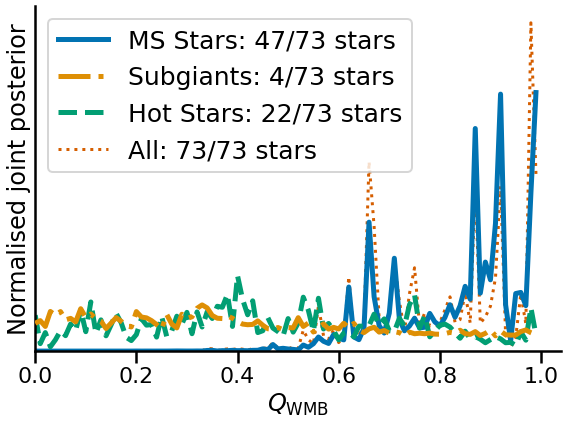

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
y = np.prod(hists_sel_cov[ms], axis=0)
ax.plot(bins[:-1], y / np.mean(y), lw=5, zorder=1,
        label=fr'MS Stars: {len(hists_sel_cov[ms])}/{len(c2[sel])} stars')

y = np.prod(hists_sel_cov[sg], axis=0)
ax.plot(bins[:-1], y / np.mean(y), ls='-.', zorder=3, lw=5,
        label=fr'Subgiants: {len(hists_sel_cov[sg])}/{len(c2[sel])} stars')

y =  np.prod(hists_sel_cov[h], axis=0)
ax.plot(bins[:-1], y / np.mean(y), ls='--', zorder=2, lw=5,
        label=fr'Hot Stars: {len(hists_sel_cov[h])}/{len(c2[sel])} stars')
                       
y = np.prod(hists_sel_cov, axis=0)
ax.plot(bins[:-1], y / np.mean(y), ls=':', zorder=0,
        label=fr'All: {len(hists_sel_cov)}/{len(c2[sel])} stars')


ax.set_ylabel(r'Normalised joint posterior')
ax.set_xlabel(r'$Q_{\rm WMB}$')
ax.set_yticks([])
# ax.set_yscale('log')
ax.set_ylim(0)
ax.set_xlim(0)
ax.legend(loc='upper left', fontsize=25)

sns.despine()
fig.tight_layout()
# plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/type_comparison.png', bbox_inches='tight', dpi=300)
# plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/type_comparison.pdf', bbox_inches='tight', rasterized=True)
plt.show()

In [17]:
fsel = ati['KIC'].isin(c2[sel]['KIC'])
f_post_pa = np.array(post_pa)[fsel]

In [18]:
y = np.prod(hists_sel_cov[ms], axis=0)

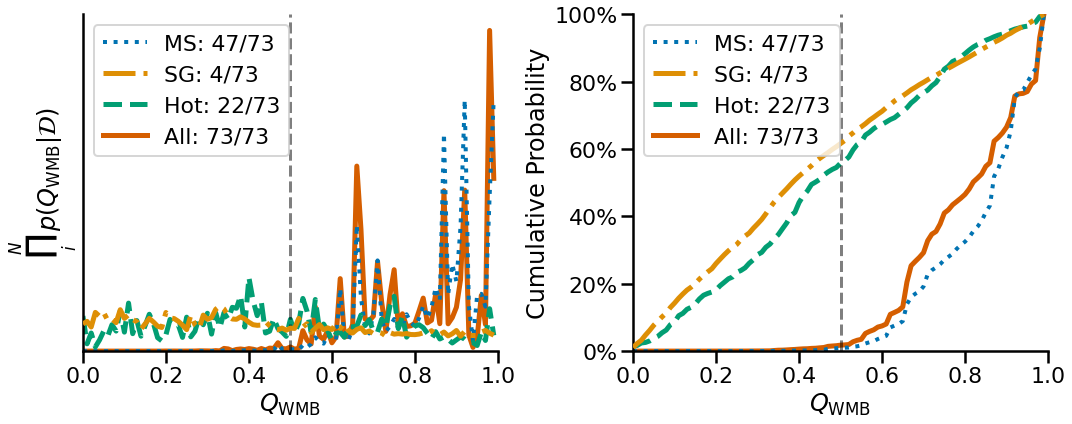

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

y = np.prod(hists_sel_cov[ms], axis=0)
ax[0].plot(bins[:-1], y/np.sum(y), lw=4, ls=':', zorder=1,
        label=fr'MS: {len(hists_sel_cov[ms])}/{len(c2[sel])}')

y = np.prod(hists_sel_cov[sg], axis=0)
ax[0].plot(bins[:-1], y/np.sum(y), ls='-.', zorder=3, lw=5,
        label=fr'SG: {len(hists_sel_cov[sg])}/{len(c2[sel])}')

y =  np.prod(hists_sel_cov[h], axis=0)
ax[0].plot(bins[:-1], y/np.sum(y), ls='--', zorder=2, lw=5,
        label=fr'Hot: {len(hists_sel_cov[h])}/{len(c2[sel])}')
                       
y = np.prod(hists_sel_cov, axis=0)
ax[0].plot(bins[:-1], y/np.sum(y), lw=5, zorder=0,
        label=fr'All: {len(hists_sel_cov)}/{len(c2[sel])}')


ax[0].set_xlabel(r'$Q_{\rm WMB}$')
ax[0].set_ylabel(r'$\prod_i^N\ p(Q_{\rm WMB} | \mathcal{D})$')
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)
ax[0].legend(loc='upper left')
ax[0].axvline(0.5, c='k', alpha=.5, ls='--')

y = np.prod(hists_sel_cov[ms], axis=0)
rcc = np.cumsum(y)
ax[1].plot(bins[:-1], rcc/rcc[-1]*100, lw=4, ls=':', zorder=1,
        label=fr'MS: {len(hists_sel_cov[ms])}/{len(c2[sel])}')

y = np.prod(hists_sel_cov[sg], axis=0)
rcc = np.cumsum(y)
ax[1].plot(bins[:-1],rcc/rcc[-1]*100, ls='-.', zorder=3, lw=5,
        label=fr'SG: {len(hists_sel_cov[sg])}/{len(c2[sel])}')

y =  np.prod(hists_sel_cov[h], axis=0)
rcc = np.cumsum(y)

ax[1].plot(bins[:-1],rcc/rcc[-1]*100, ls='--', zorder=2, lw=5,
        label=fr'Hot: {len(hists_sel_cov[h])}/{len(c2[sel])}')
                       
y = np.prod(hists_sel_cov, axis=0)
rcc = np.cumsum(y)

ax[1].plot(bins[:-1], rcc/rcc[-1]*100, lw=5, zorder=0,
        label=fr'All: {len(hists_sel_cov)}/{len(c2[sel])}')
ax[1].set_ylabel(r'Cumulative Probability')
ax[1].set_xlabel(r'$Q_{\rm WMB}$')
ax[1].axvline(0.5, c='k', alpha=.5, ls='--')
ax[1].legend(loc='upper left')
ax[1].set_ylim(0, 100)
ax[1].set_xlim(0, 1)
ax[1].set_yticklabels([f'{n}%' for n in np.arange(0, 120, 20)])
               
sns.despine()

fig.tight_layout()
plt.savefig('/Users/Oliver/PhD/malatium/paper/natastron/2nd_draft/Images/modelresults.pdf', bbox_inches='tight',rasterized=True)
plt.show()